 # A simple test of the FDMT class - useful for debugging
## Create the FDMT
You'll need python2.7, numpy and the directory ../python in your pythonpath

In [1]:
%matplotlib inline
import numpy as np
import fdmt # you'll need to have ../python in  you PYTHONPATH
from pylab import *
reload(fdmt)


<module 'fdmt' from '/Users/ban115/bolton/craft/code/python/fdmt.pyc'>

In [2]:
nf = 256 # number of channels - must be a power of 2 currently.
fmax = 1440. #  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 512 # Number of samples per block
tsamp = 1.0 # milliseconds
thefdmt = fdmt.Fdmt(fmin, df, nf, nd, nt) # make FDMT


Iteration 1 2.0 2.0 2.0 False
Iteration 2 4.0 4.0 4.0 False
Iteration 3 8.0 8.0 8.0 False
Iteration 4 16.0 16.0 16.0 False
Iteration 5 32.0 32.0 32.0 False
Iteration 6 64.0 64.0 64.0 False
Iteration 7 128.0 128.0 128.0 False
Iteration 8 256.0 256.0 256.0 False


# Simulating an FRB and finding it with the FDMT
Here we make a simple simulation of an FRB. There are much more correct and sophisticated ways of doing thus, but this will do for now. We DM and time offset such that sweep starts and finishes in the current block. Handling larger DMs or offsets where the FRB finishes in the next block is the subject of the 'overlap-and-sum' buffer - a downstream process.


(256, 512) 254.80224303304712


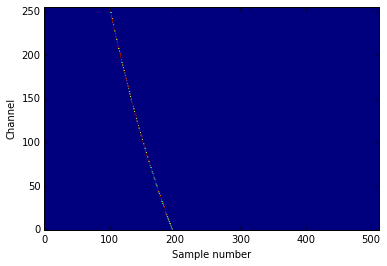

In [3]:
import simfrb # in same directory as fdmt
reload(simfrb)

# I haven't had time to tidy this up - the untis are funny and the FRB is updside down and transposed
# With respect to what the FDMT wants to see - just trust me OK.
# Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=100, ntimes=nt, offset=100).T
frb = np.flipud(frb)
print frb.shape, frb.sum()
imshow(frb, aspect='auto', origin='lower')
xlabel('Sample number')
ylabel('Channel')


We run the FDMT on this FRB and we get the next image. THe key point is that it has a peak in at that should (ideally) correspond to the sum over all the FRB sweep, and the position of the peak should be at the correct DM and time - a unit test that tests this exhaustively would be ideal. The time of the peak should be the time when the FRB crosses channel 0, and the DM should be the DM of the FRB. Caution:  DM units the FDMT uses are in *samples* - i.e. how many samples the FRB took to get from the top channel to the bottom channel. In the code this is often refgerred to as 'dt' or 'idt' or 'ndt'. The units for the simulator are in pc/cm3 - which at the simulated frequency and time resolution, happens to be rather similar, which is a fluke.


In [4]:
# Execute the FDMT of a single block. This doesn't do overlap-and-sum which is a separate thing again.
fout = thefdmt(frb) 

Hitting efficiency 0.8546583166818794 Maximum at t= 196 idt= 96 = 100.10314663532175 pc/cm3


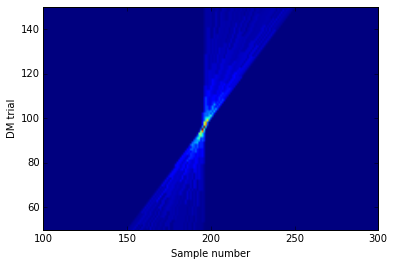

In [13]:
imshow(fout, origin='lower', aspect='auto')
hitting_efficiency = fout.max()/frb.sum() # should be close to 1. Ideally 1.
maxidx = fout.argmax()
idtmax, tmax = np.unravel_index(maxidx, fout.shape)
dm_of_idt = idtmax*tsamp/(4.15*((fmin/1e3)**-2 - (fmax/1e3)**-2)) # convert idt to pc/cm3
print 'Hitting efficiency', hitting_efficiency, 'Maximum at t=', tmax, 'idt=', idtmax, '=', dm_of_idt, 'pc/cm3'
xlim(100,300)
ylim(50,150)
xlabel('Sample number')
ylabel('DM trial')

## Unit Tests I'll do in future.
I really need to convert these into unit tests, but this gives you some idea of what we could do, in addition to testing the FDMT of an FRB looks as expected.

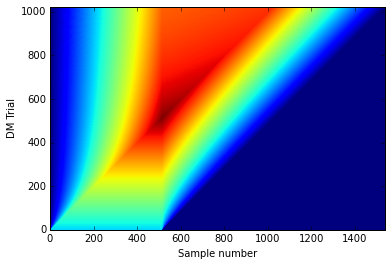

In [6]:
# Test the FDMT of ones looks as expected.
frbone = np.ones((nf, nt))
frbone_out = thefdmt(frbone)
imshow(frbone_out, origin='lower', aspect='auto')
xlabel('Sample number')
ylabel('DM Trial')

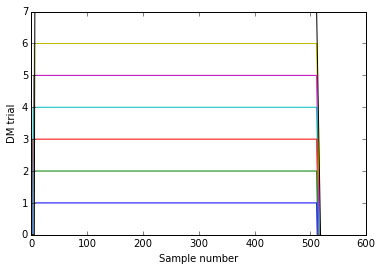

In [7]:
# Test the initialisation of the FDMT looks as expected
frbone_init = thefdmt.initialise(frbone)
plot(frbone_init[0, :, :].T)
xlabel('Sample number')
ylabel('DM trial')

# Implementation tips and possible improvements
## Caching improvements
The astute among you will notice that in the process of doing the iterations, sometimes the output is the sum of 2 DM trials (indexed as "id" or "idt") that either you loaded previously, or the the sum of 2 trials with the same idt but with some offset between them. Here we quantify how often that happens - which happens to be quite a lot. Around 50% of the time. My guess is that this happens most often in the earlier iterations, but I leave that as an exercise for the reader

In [8]:
id1_cache_hits = 0.
id2_cache_hits = 0.
identical_cache_hits = 0.
ncalls = 0.
nflops = 0.
for iterconfig in thefdmt.hist_nf_data: # loop over iterations
    for chanconfig in iterconfig: # loop over output subbands
        last_id1 = None
        last_id2 = None
        for dmconfig in chanconfig[-1]: # loop over output DM trials in that subband
            _, id1, offset, id2, _, _, _ = dmconfig
            ncalls += 1
            nflops += thefdmt.n_t - offset # rough - need to fix.
            if id1 == last_id1:
                id1_cache_hits += 1
                
            if id2 == last_id1:
                id2_cache_hits += 1
                
            if id1 == id2:
                identical_cache_hits += 1
                
            last_id1 = id1
            last_id2 = id2
                
print 'Cache hits ID1=', id1_cache_hits, 'ID2=', id2_cache_hits, 'ID1==ID2', identical_cache_hits
print 'Cache hit ratio ID1=', id1_cache_hits/ncalls, 'ID2=', id2_cache_hits/ncalls, 'Identical=', identical_cache_hits/ncalls
print 'Number of vector sums calls', ncalls, 'nflops', nflops, 'GFlops/sec', nflops/float(nt)/tsamp*1e3/1e9

Cache hits ID1= 3954.0 ID2= 4801.0 ID1==ID2 2583.0
Cache hit ratio ID1= 0.461269248717 ID2= 0.560079328045 Identical= 0.301329911339
Number of vector sums calls 8572.0 nflops 3804774.0 GFlops/sec 0.00743119921875


## State shapes & pingpong buffers
FDMT execute() does stats by initialising the data to make a 'state', then executes an iteration on that state to make a new state. You then use that state as the input to the next iteration. This is conveniently implemented as a pingpong buffe. Just to make the point: the shape of the buffers changes with iteration and the sizes are not constant. So you need to malloc the largest size and then just pretend to make the sizes change without re-mallocing everything. The axes are (channel, dmtrial, time). The largest state is not necessarily the last. FREDDA looks through  the state shapes an allocates 2 buffers of the same size, both of the largest size - that's safe but a little inefficient.

In [9]:
for stateshape in thefdmt.hist_state_shape:
    print 'State shape is', stateshape, 'size is', stateshape.prod(), 'elements'

State shape is [256   7 519] size is 930048 elements
State shape is [128  12 524] size is 804864 elements
State shape is [ 64  23 535] size is 787520 elements
State shape is [ 32  44 556] size is 782848 elements
State shape is [ 16  85 597] size is 811920 elements
State shape is [  8 166 678] size is 900384 elements
State shape is [  4 317 829] size is 1051172 elements
State shape is [   2  588 1100] size is 1293600 elements
State shape is [   1 1024 1536] size is 1572864 elements


## Clever addressing / saving memory / flops
Below is the FDMT of ones. You'll notice that there's a triangle at the bottom right that's all white (because I made in 'nan') , i.e. 0. This is because those DM trials finished in previous blocks. (It takes a while to explain, I can do it later). In any case, we're allocating a nice big square here, and never using about 1/3 of it. Clever malloc-ing and addressing would improve the memory usage (quantity and bandwidth). The blue on the left shouldn't be zero - I still need to initialise the early stuff based on teh previous block. *sigh*. This doesn't include overlap and sum yet.

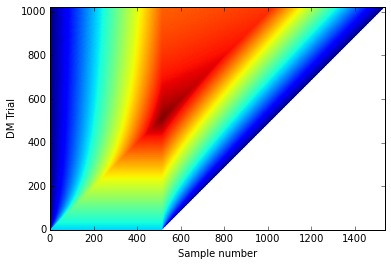

In [10]:
# Test the FDMT of ones looks as expected.
frbone = np.ones((nf, nt))
frbone_out = thefdmt(frbone)
frbone_out[frbone_out == 0] = np.nan
imshow(frbone_out, origin='lower', aspect='auto')
xlabel('Sample number')
ylabel('DM Trial')